# Logistic Regression
Binary Classification + Muticlassification (without none)


### Import necessary packages

In [1]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import pandas as pd

import mlflow
import logging 
import config 

from basic_functions import (
    get_preprocess_data,
    get_lemmatized_data,
    get_metrics
)


/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup

In [2]:
MODEL_NAME = "logistic_regression" 
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [9]:
DATA_PATH = "../data/data_small.csv"

## Two-Step-Approach

In [ ]:
#setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "LogReg 2step")
mlflow.log_param("dataset", DATA_PATH)


Active run_id: 547ba20aa0954e76a8eddadb82d298e3


### Get and process data

In [11]:
df = get_preprocess_data(DATA_PATH)

In [12]:
def binary_classification(x):
    if x == 'none':
        return 'none'
    else:
        return 'fallacy'

In [13]:
df_binary = df.copy()
df_binary['two_class_target'] = df_binary['logical_fallacies'].apply(binary_classification)

In [14]:
df_multi_class = df.copy()
df_multi_class = df_multi_class[df_multi_class["logical_fallacies"] != 'none']

In [15]:
# nltk.download('wordnet') commented because downloaded once.

### Lemmatize text

In [16]:
df_binary = get_lemmatized_data(df_binary)
df_multi_class = get_lemmatized_data(df_multi_class)

### Train-test split

In [17]:
y_binary = df_binary[["two_class_target", "logical_fallacies"]]
X_binary = df_binary["text"]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_binary, y_binary, test_size=0.30, random_state=42, stratify=y_binary)

In [18]:
fa_train = y_train_b["logical_fallacies"]
y_train_b = y_train_b["two_class_target"]

In [19]:
fa_test = y_test_b["logical_fallacies"]
y_test_b = y_test_b["two_class_target"]

In [20]:
y_multi = df_multi_class["logical_fallacies"]
X_multi = df_multi_class["text"]

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi, test_size=0.30, random_state=42, stratify=y_multi)

### Logistic Regression

#### thoughts for the moment

- pipeline one: binary first, classification next 
- pipeline 2: classification from the get-go
- add stemming? Not now, since we have the lemmatization
- add bag of words? not now
- For a multi_class problem, 
    - multi_class = “multinomial” 
- class weigh = balanced

In [21]:
# Use TF-IDF Vecorizer to transform text into numerical data
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Bigrams (or even trigrams)
    max_features=5000,   # Limit feature space to the most important words
    min_df=5,            # Consider words that appear in at least 5 documents
    max_df=0.9           # Ignore words that appear in more than 90% of documents
)
X_vectorized_b = tfidf_vectorizer.fit_transform(X_train_b)
X_vectorized_test_b = tfidf_vectorizer.transform(X_test_b)

In [22]:
# for the multi calss
tfidf_vectorizer_m = TfidfVectorizer(
    ngram_range=(1, 2),  # Bigrams (or even trigrams)
    max_features=5000,   # Limit feature space to the most important words
    min_df=5,            # Consider words that appear in at least 5 documents
    max_df=0.9           # Ignore words that appear in more than 90% of documents

)
X_vectorized_m = tfidf_vectorizer_m.fit_transform(X_train_m)
X_vectorized_test_m = tfidf_vectorizer_m.transform(X_test_m)

### Initialize the model

#### Binary classification

In [23]:
bin_model = LogisticRegression(
    penalty='l2',  # most of the solvers only work with l2
    random_state=42, 
    verbose=0, 
    n_jobs=-1, 
    )

In [24]:
# Grid search for binary classification
param_grid_bin = {
'C': [0.1, 1, 10, 100],
'max_iter': [100, 500, 1000],
'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear']
}

In [25]:
grid_search_b = GridSearchCV(bin_model, param_grid_bin, cv=5)
grid_search_b.fit(X_vectorized_b, y_train_b)

best_params_b = grid_search_b.best_params_
print(best_params_b)



/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have

{'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}


/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-pack

In [33]:
# log params for binary model
for k,v in best_params_b.items():
    mlflow.log_param(f"binary_best_param_{k}", v)

In [34]:

# Predict on train and test data
best_model_b = grid_search_b.best_estimator_
y_train_pred_b = best_model_b.predict(X_vectorized_b)
y_test_pred_b = best_model_b.predict(X_vectorized_test_b)


#### Multi-class classification

In [35]:
multi_model = LogisticRegression(
    penalty='l2',  # most of the solvers only work with l2
    class_weight= "balanced", 
    random_state=42, 
    multi_class='multinomial', 
    verbose=0, 
    n_jobs=-1, 
    )

In [36]:

# Grid search
param_grid_multi = {
'C': [0.1, 1, 10, 100],
'max_iter': [100, 500, 1000],
'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
}

In [37]:
grid_search_m = GridSearchCV(multi_model, param_grid_multi, cv=5)
grid_search_m.fit(X_vectorized_m, y_train_m)

best_params_m = grid_search_m.best_params_
print(best_params_m)

/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproces

{'C': 10, 'max_iter': 500, 'solver': 'saga'}


In [ ]:
# log params for binary model
for k,v in best_params_m.items():
    mlflow.log_param(f"mulit_best_param_{k}", v)

In [39]:

# Predict on train and test data
best_model_m = grid_search_m.best_estimator_
y_train_pred_m = best_model_m.predict(X_vectorized_m)



In [40]:
# # Save model to pickle file:
# with open('../models/svm/svm_model.pkl', 'wb') as f:
#     pickle.dump(best_model, f)

#### Two-step approach

In [41]:
df_pred =  pd.DataFrame({"text": X_test_b, "logical_fallacies": fa_test , "two_class_target": y_test_b, "binary_prediction": y_test_pred_b})
df_pred.head()

,text,logical_fallacies,two_class_target,binary_prediction
dataset,,,,
2,you should marry me i know we re not compatibl...,appeal_to_emotion,fallacy,fallacy
9,my friend phyllis hunter is here she had one o...,appeal_to_authority,fallacy,fallacy
2,either we raise tax or we ll have no public se...,false_dilemma,fallacy,fallacy
8,i dont want people to die that is so sad and m...,appeal_to_emotion,fallacy,fallacy
2,of course she s saying that it s popular to su...,ad_hominem,fallacy,fallacy


In [42]:
df_pred = df_pred[df_pred["binary_prediction"] != "none"]

In [43]:
X_df_pred = tfidf_vectorizer_m.transform(df_pred["text"])
X_df_pred

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16755 stored elements and shape (586, 1654)>

In [44]:
y_test_pred_m = best_model_m.predict(X_df_pred)


### Evaluation


In [51]:
def log_metrics(cr, split):
    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

INFO:root:get test metrics for the two step approach
INFO:basic_functions:classification_report
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/li

                       precision    recall  f1-score   support

           ad_hominem       0.58      0.57      0.58       101
  appeal_to_authority       0.46      0.68      0.55        87
    appeal_to_emotion       0.44      0.56      0.49       100
        false_dilemma       0.69      0.76      0.72        99
faulty_generalization       0.33      0.40      0.36       101
                 none       0.00      0.00      0.00        98

             accuracy                           0.49       586
            macro avg       0.42      0.49      0.45       586
         weighted avg       0.42      0.49      0.45       586

[[58  8 20  3 12  0]
 [ 5 59 11  4  8  0]
 [14  8 56  5 17  0]
 [ 7  8  2 75  7  0]
 [ 7 22 22 10 40  0]
 [ 9 24 16 11 38  0]]


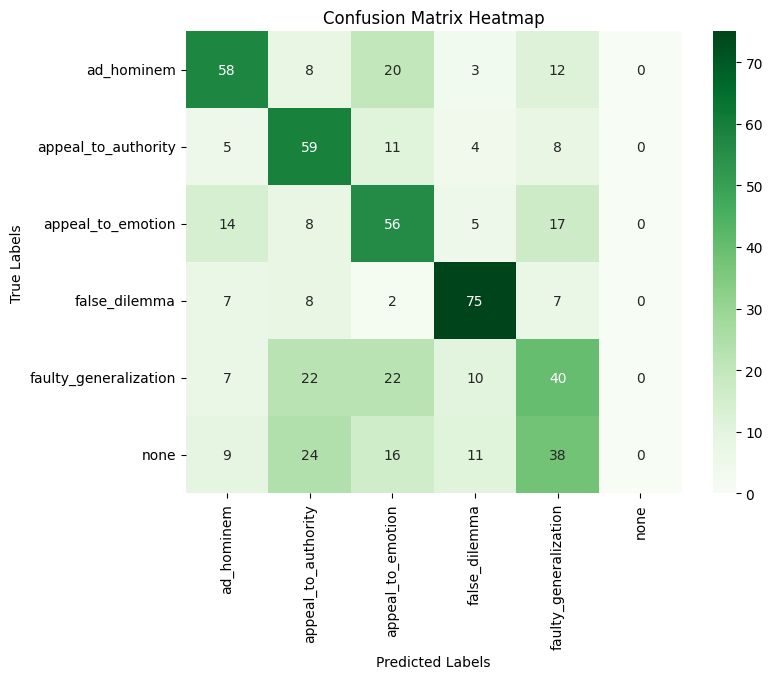

test_ad_hominem_precision 0.58
test_ad_hominem_recall 0.57
test_ad_hominem_f1-score 0.58
test_ad_hominem_support 101
test_appeal_to_authority_precision 0.46
test_appeal_to_authority_recall 0.68
test_appeal_to_authority_f1-score 0.55
test_appeal_to_authority_support 87
test_appeal_to_emotion_precision 0.44
test_appeal_to_emotion_recall 0.56
test_appeal_to_emotion_f1-score 0.49
test_appeal_to_emotion_support 100
test_false_dilemma_precision 0.69
test_false_dilemma_recall 0.76
test_false_dilemma_f1-score 0.72
test_false_dilemma_support 99
test_faulty_generalization_precision 0.33
test_faulty_generalization_recall 0.4
test_faulty_generalization_f1-score 0.36
test_faulty_generalization_support 101
test_none_precision 0.0
test_none_recall 0.0
test_none_f1-score 0.0
test_none_support 98
test_accuracy 0.49
test_macro avg_precision 0.42
test_macro avg_recall 0.49
test_macro avg_f1-score 0.45
test_macro avg_support 586
test_weighted avg_precision 0.42
test_weighted avg_recall 0.49
test_weighted 

In [50]:
logger.info('get test metrics for the two step approach')
classification_report_test = get_metrics(df_pred["logical_fallacies"], y_test_pred_m)
log_metrics(classification_report_test, "test")

INFO:root:get train metrics for binary classification
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


              precision    recall  f1-score   support

     fallacy       0.83      1.00      0.91      1144
        none       0.97      0.11      0.20       256

    accuracy                           0.84      1400
   macro avg       0.90      0.56      0.56      1400
weighted avg       0.86      0.84      0.78      1400

[[1143    1]
 [ 227   29]]


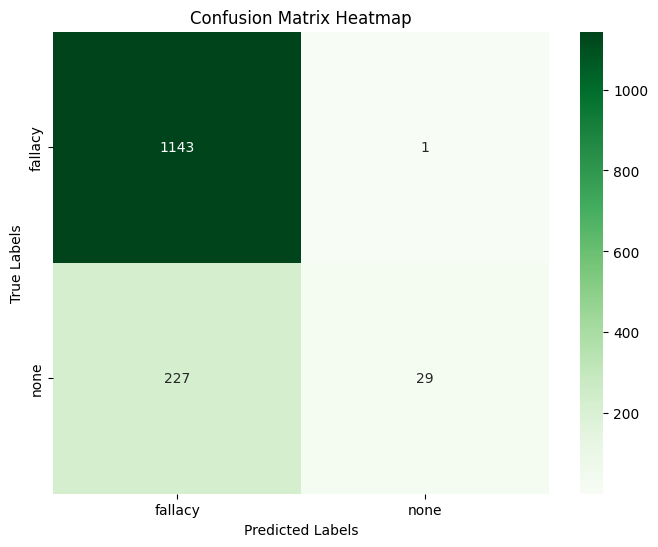

In [52]:
logger.info('get train metrics for binary classification')
classification_report_b_train = get_metrics(y_train_b, y_train_pred_b)
log_metrics(classification_report_b_train, "train")

In [44]:
logger.info('get train metrics for multi classification')
classification_report_m_train = get_metrics(y_train_m, y_train_pred_m)
# log_metrics(classification_report_m_train, "train")

INFO:root:get train metrics for multi classification
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix


                       precision    recall  f1-score   support

           ad_hominem       0.98      0.99      0.99       326
  appeal_to_authority       1.00      1.00      1.00       229
    appeal_to_emotion       1.00      0.99      0.99       486
        false_dilemma       1.00      1.00      1.00       299
faulty_generalization       1.00      1.00      1.00       445

             accuracy                           1.00      1785
            macro avg       1.00      1.00      1.00      1785
         weighted avg       1.00      1.00      1.00      1785

[[324   0   2   0   0]
 [  0 229   0   0   0]
 [  5   0 480   0   1]
 [  0   0   0 299   0]
 [  0   0   0   0 445]]


In [53]:
mlflow.end_run()

🏃 View run LogReg 2step at: http://127.0.0.1:5001/#/experiments/118053630762497624/runs/547ba20aa0954e76a8eddadb82d298e3
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/118053630762497624
